# Gmv loss MFCs vs Partners

## Executive summary

In this notebook, we anlayse 2 metrics: (i) % Groceries ordres with PNA and (ii) GMV Loss per Groceries order. 

Context: MFCs vs Partners test, where some users have the MFCs options availabile, while others do not see MFCs.

We want to observe if metrics (i) and (ii) change between control (who see the MFCs) and treat (who do not see the MFCs)

**Params**
- Only subvertical2 --> Groceries
- Start date: 2023-11-28
- End date: 2024-01-27
- Cities: LIS, BUC, BCN, ZAG, BEG

**Business questions answered:**

- **% Orders with PNA?** --> Cumulative effect in absolut perc points where we add for each day the difference in perc. So if Treat had 5% PNA and Control 3%, that day accounts for an effect of 2%. We add up all the effects in the cumulative metric. 

        - BCN --> +600%
        - BEG --> +200%
        - BUC --> +250%
        - LIS --> +600%
        - ZAG --> +150%
        - All cities --> +400%
        
- **% GMV loss?** --> Cumulative effect in absolut perc points

        - BCN --> +150%
        - BEG --> +75%
        - BUC --> +80%
        - LIS --> +150%
        - ZAG --> +20%
        - All cities --> +110%

- **% GMV loss absolute value?** --> Cumulative effect in absolut perc points

        - Test --> -1.30€
        - Control --> -1.06€

## Plan

Business question to answer
- [X] Does % PNA increase between control and treat?
- [X] Does GMV loss per order increase between control and treat?

Tasks
- [X] Define global params
- [X] Develop a query to obtain customers test groups
- [X] Develop query to obtain % of orders with PNA
- [X] Develop query to obtain GMV loss per Groceries order
- [X] Table results grouped by city/country/group... as needed to properly communicate
- [X] Plot pre-during-post line plot with shade
- [X] Plot histogram of % variations
- [X] Compute final cumulative absolute value of GMV loss 

Conclusions
- [X] Anything to add to knowledge
- [X] Any query to add to repo

## Config

In [1]:
import matplotlib.pyplot as  plt
import pandas as pd
import seaborn as sns
import sys

sys.path.append('c:\\Users\\Jordi Cremades\\Documents\\Repository')

# from utils import dataset_meta_stats
# from utils import dataset_stats
from utils import query_engines

# dms = dataset_meta_stats.DatasetMetaStats() 
# ds = dataset_stats.DatasetStats()

## Global params

In [3]:
#query object
START_TEST = '2023-11-28'
END_TEST = '2024-01-27'
TEST_GROUPS = ["'Test Group'", "'Control Group'"]
list_test_groups = ",".join(str(val) for val in TEST_GROUPS)
EXPERIMENTATION_TOGGLE_ID = 'LGSD_MFC_OR_PARTNERS_ET'
CITY_CODES = ["'LIS'", "'BUC'", "'BCN'", "'ZAG'", "'BEG'"]
list_city_codes = ",".join(str(val) for val in CITY_CODES)
MORE_LESS_DAYS = 30

params = [
    {'name':'start_test', 'value':START_TEST}
    ,{'name':'end_test', 'value':END_TEST}
    ,{'name':'experimentation_toggle_id', 'value':EXPERIMENTATION_TOGGLE_ID}
    ,{'name':'test_groups', 'value':list_test_groups}
    ,{'name':'more_less_days', 'value':str(MORE_LESS_DAYS)}
    ,{'name':'cities', 'value':list_city_codes}
]

colors = {'Test Group': '#FF7F0E', 
          'Control Group': '#1F77B4',
          'Other': '#7F7F7F'}

## Task 1: Develop query to obtain % of orders with PNA

In [168]:
q = query_engines.QueryEngines(
    query='customers_groups.sql', 
    params=params,
    load_from_output_file='output_experiment_groups', #with no .csv
    output_file='output_experiment_groups', #with no .csv
    printq=None
)

df = q.query_run_starbust()
df

,customer_id,experiment_group
0,9888891,Control Group
1,144995305,Control Group
2,2983679,Test Group
3,1866983,Control Group
4,104260127,Control Group
...,...,...
2089012,163855610,Control Group
2089013,163824899,Control Group
2089014,88603355,Control Group
2089015,48108254,Control Group


In [169]:
#distribution of customers
df.groupby('experiment_group')['customer_id'].nunique()

experiment_group
Control Group    1880128
Test Group        208889
Name: customer_id, dtype: int64

In [170]:
#does any customer have multiple groups?
# A: NO, perfect
df['customer_id'].duplicated().sum()

0

In [171]:
#What % is variant?
# A: 10%
df.groupby('experiment_group')['customer_id'].nunique()/len(df['customer_id'])

experiment_group
Control Group    0.900006
Test Group       0.099994
Name: customer_id, dtype: float64

## Task 2: Develop query to obtain % of orders with PNA

In [209]:
q = query_engines.QueryEngines(
    query='perc_orders_pna.sql', 
    params=params,
    load_from_output_file='perc_orders_with_pna', #with no .csv
    output_file='perc_orders_with_pna', #with no .csv
    printq=None
)

df = q.query_run_starbust()

By cities

In [210]:
#dataframe format
df['p_creation_date'] = pd.to_datetime(df['p_creation_date'])

df['total_orders_with_pna'] = df['total_orders_with_pna'].fillna(0)
df['total_orders'] = df['total_orders'].fillna(0)

df['perc_orders_with_pna'] = df['total_orders_with_pna']/df['total_orders']

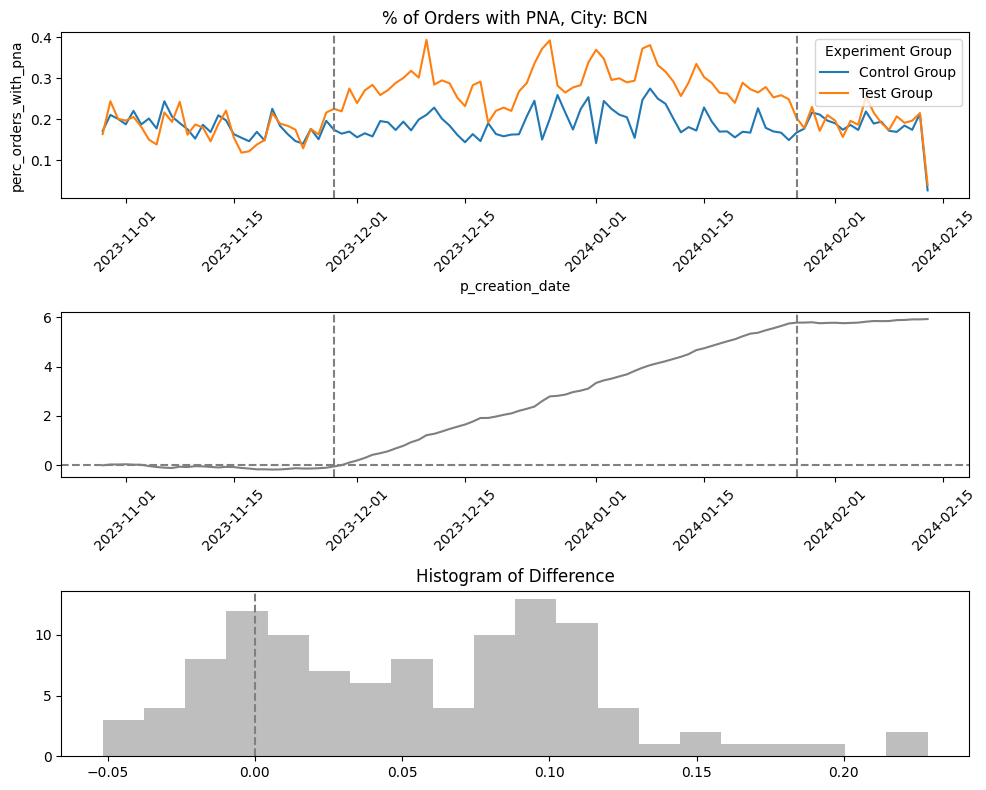

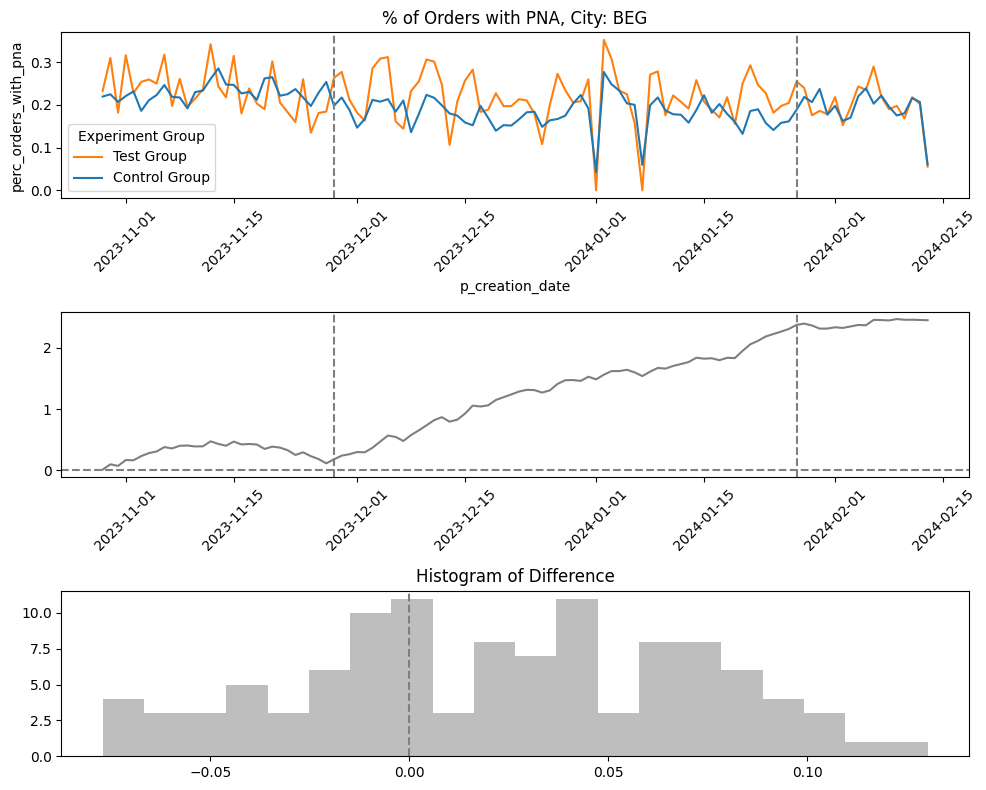

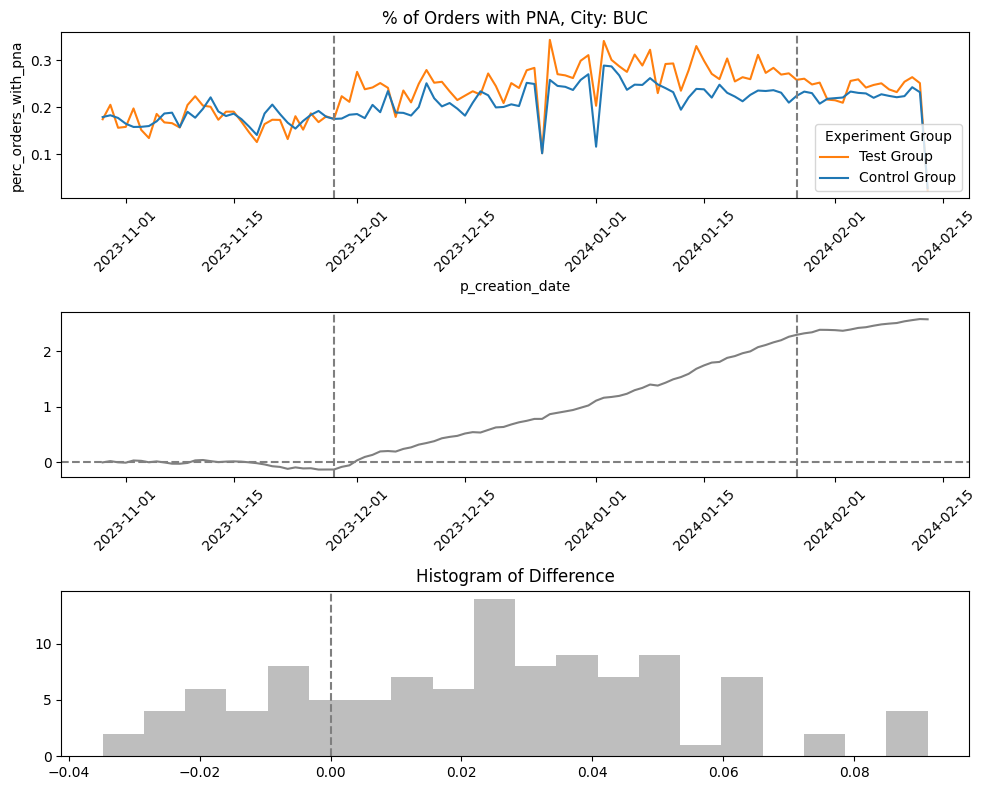

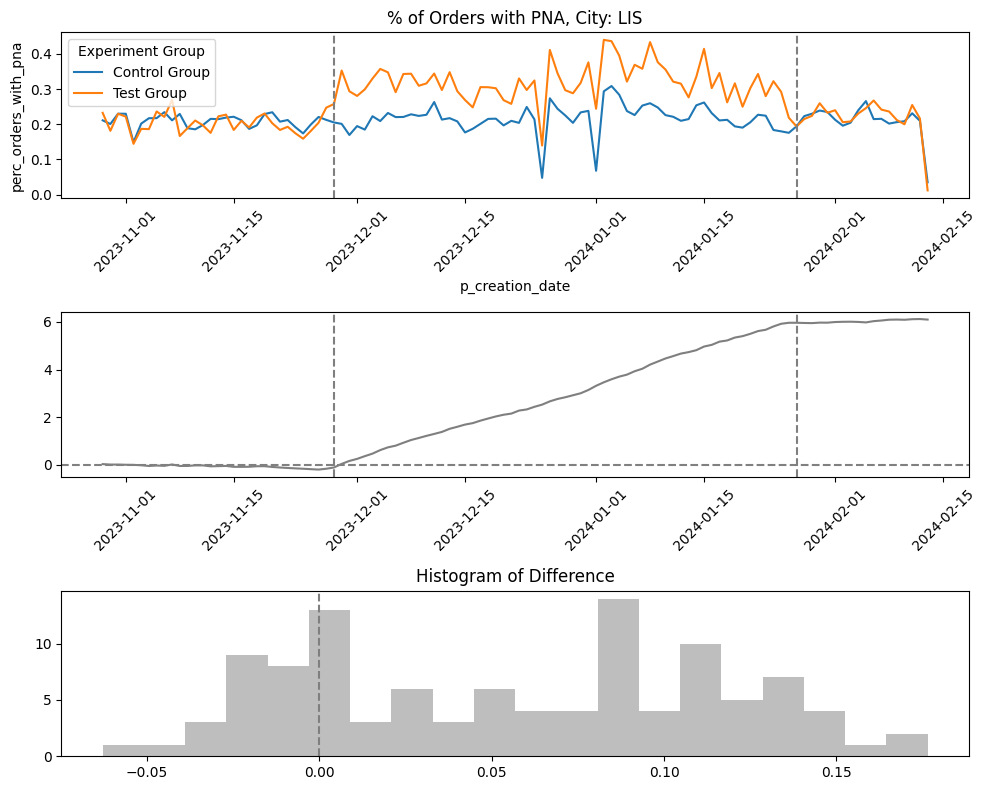

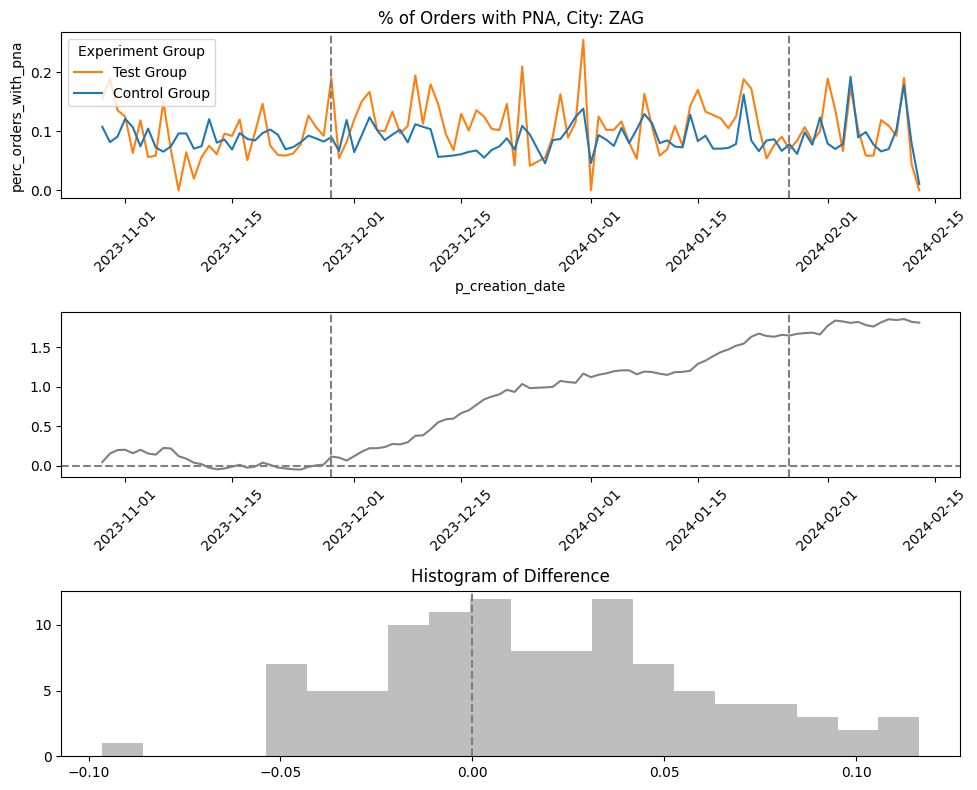

In [211]:
grouped = df.groupby('order_city_code')

for city, group_data in grouped:
    plt.figure(figsize=(10, 8))
    
    #lineplot
    plt.subplot(3, 1, 1)
    plt.title(f'% of Orders with PNA, City: {city}')
    sns.lineplot(data=group_data, 
                 x='p_creation_date', 
                 y='perc_orders_with_pna', 
                 hue='experiment_group', 
                 palette=colors)
    plt.xticks(rotation=45)
    plt.axvline(x=pd.to_datetime(START_TEST), color=colors['Other'], linestyle='--')
    plt.axvline(x=pd.to_datetime(END_TEST), color=colors['Other'], linestyle='--')
    plt.legend(title='Experiment Group')
    
    # Calculate the cumulative difference between Test and Control Group
    diff_series = group_data.pivot(index='p_creation_date', columns='experiment_group', values='perc_orders_with_pna')['Test Group'] - group_data.pivot(index='p_creation_date', columns='experiment_group', values='perc_orders_with_pna')['Control Group']
    cumulative_diff = diff_series.cumsum()
    
    # Plot the second graph
    plt.subplot(3, 1, 2)
    plt.plot(cumulative_diff.index, cumulative_diff.values, color=colors['Other'])
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(x=pd.to_datetime(START_TEST), color=colors['Other'], linestyle='--')
    plt.axvline(x=pd.to_datetime(END_TEST), color=colors['Other'], linestyle='--')
    plt.xticks(rotation=45)
    
    # Plot the third graph (histogram of difference values)
    plt.subplot(3, 1, 3)
    plt.hist(diff_series.dropna(), bins=20, color=colors['Other'], alpha=0.5)  # Adjust the number of bins as needed
    plt.axvline(x=0, color=colors['Other'], linestyle='--')
    plt.title('Histogram of Difference')


    plt.tight_layout()
    plt.show()

All cities

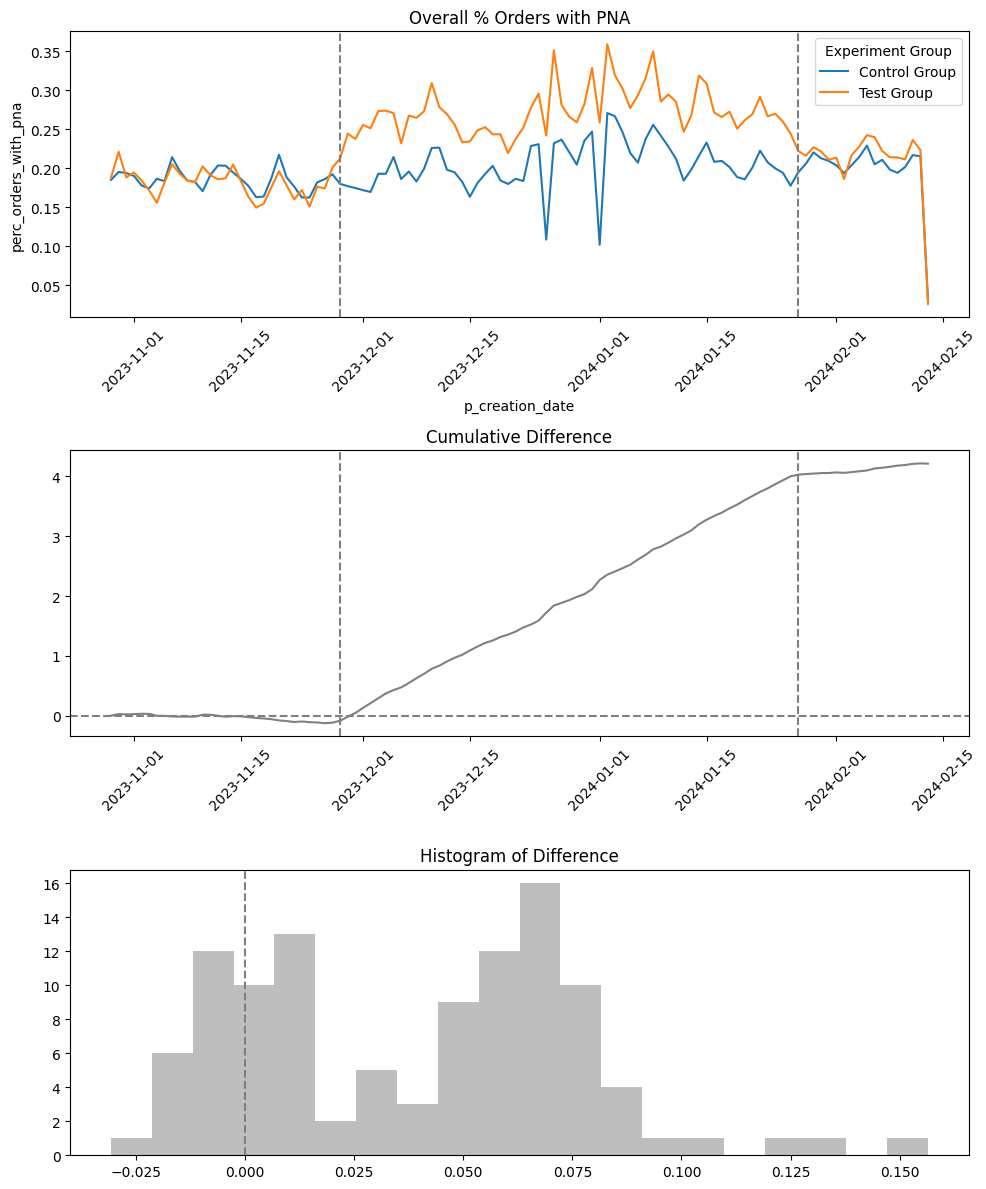

In [212]:
#all cities together
tot_cities = df.groupby(['p_creation_date','experiment_group'])[['total_orders_with_pna','total_orders']].sum()
tot_cities['perc_orders_with_pna'] = abs(tot_cities['total_orders_with_pna'])/tot_cities['total_orders']
tot_cities = tot_cities.reset_index()

plt.figure(figsize=(10, 12))

# Lineplot
plt.subplot(3, 1, 1)
plt.title('Overall % Orders with PNA')
sns.lineplot(data=tot_cities, 
             x='p_creation_date', 
             y='perc_orders_with_pna', 
             hue='experiment_group',
             palette=colors)
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime(START_TEST), color=colors['Other'], linestyle='--')
plt.axvline(x=pd.to_datetime(END_TEST), color=colors['Other'], linestyle='--')
plt.legend(title='Experiment Group')

# Calculate the cumulative difference between Test and Control Group
diff_series = tot_cities.pivot(index='p_creation_date', columns='experiment_group', values='perc_orders_with_pna')['Test Group'] - tot_cities.pivot(index='p_creation_date', columns='experiment_group', values='perc_orders_with_pna')['Control Group']
cumulative_diff = diff_series.cumsum()

# Plot the second graph (line plot of cumulative difference)
plt.subplot(3, 1, 2)
plt.plot(cumulative_diff.index, cumulative_diff.values, color='gray')
plt.axhline(0, color=colors['Other'], linestyle='--')
plt.axvline(x=pd.to_datetime(START_TEST), color=colors['Other'], linestyle='--')
plt.axvline(x=pd.to_datetime(END_TEST), color=colors['Other'], linestyle='--')
plt.xticks(rotation=45)
plt.title('Cumulative Difference')

# Plot the third graph (histogram of difference values)
plt.subplot(3, 1, 3)
plt.hist(diff_series.dropna(), bins=20, color=colors['Other'], alpha=0.5)  # Adjust the number of bins as needed
plt.axvline(x=0, color=colors['Other'], linestyle='--')
plt.title('Histogram of Difference')

plt.tight_layout()
plt.show()


Absolute difference Control <> Variant

In [216]:
#all cities together
tot_cities = df.groupby(['p_creation_date','experiment_group'])[['total_orders_with_pna','total_orders']].sum()
tot_cities = tot_cities.reset_index()

grouped = tot_cities.groupby('experiment_group')[['total_orders_with_pna','total_orders']].sum().reset_index()
grouped['perc_orders_with_pna'] = grouped['total_orders_with_pna']/grouped['total_orders']
grouped

,experiment_group,total_orders_with_pna,total_orders,perc_orders_with_pna
0,Control Group,278367,1404159,0.198245
1,Test Group,33096,141446,0.233983


## Task 3: Develop query to obtain GMV loss per Groceries order

In [203]:
q = query_engines.QueryEngines(
    query='perc_gmv_loss.sql', 
    params=params,
    load_from_output_file='perc_gmv_loss', #with no .csv
    output_file='perc_gmv_loss', #with no .csv
    printq=None
)

df = q.query_run_starbust()
df

,p_creation_date,order_city_code,experiment_group,total_rows,total_orders,total_value_original_eur,gmv_variation_replacement_eur,gmv_variation_partial_removal_eur,gmv_variation_total_removal_eur,gmv_variation_cx_pna_eur,refunded_to_customer_eur
0,2024-02-04,BEG,Test Group,111,111,2393.796016,0.144942,-1.687636,-79.790997,68.401199,0.801359
1,2023-11-17,ZAG,Test Group,78,78,1774.780000,0.800000,NaN,-3.880000,NaN,11.300000
2,2024-01-24,BUC,Control Group,6427,6427,170627.678566,-52.803992,-351.676241,-5724.892442,635.549329,1989.339488
3,2024-01-21,LIS,Test Group,261,261,5259.280000,-0.380000,-7.060000,-264.400000,43.760000,13.840000
4,2023-10-30,BUC,Control Group,4369,4369,110866.027745,13.371992,-260.564780,-2409.935407,334.872359,1397.127246
...,...,...,...,...,...,...,...,...,...,...,...
1073,2024-01-27,BUC,Test Group,627,627,18161.384971,5.746012,-24.493306,-510.646494,123.965751,264.314562
1074,2024-01-06,BUC,Control Group,5304,5304,140827.535109,-32.596920,-469.191582,-4190.006802,766.593035,2589.550040
1075,2023-12-15,BCN,Control Group,3807,3807,97947.090000,9.680000,-629.490000,-1909.320000,294.870000,139.590000
1076,2024-02-07,LIS,Test Group,244,244,4703.490000,1.350000,-62.600000,-220.400000,55.870000,3.450000


By cities

In [204]:
df['p_creation_date'] = pd.to_datetime(df['p_creation_date'])

df['gmv_variation_replacement_eur'] = df['gmv_variation_replacement_eur'].fillna(0)
df['gmv_variation_partial_removal_eur'] = df['gmv_variation_partial_removal_eur'].fillna(0)
df['gmv_variation_total_removal_eur'] = df['gmv_variation_total_removal_eur'].fillna(0)
df['gmv_variation_cx_pna_eur'] = df['gmv_variation_cx_pna_eur'].fillna(0)
df['refunded_to_customer_eur'] = df['refunded_to_customer_eur'].fillna(0)

df['gmv_var_total'] = df['gmv_variation_replacement_eur']+df['gmv_variation_partial_removal_eur']+df['gmv_variation_total_removal_eur']+(-1)*df['gmv_variation_cx_pna_eur']+(-1)*df['refunded_to_customer_eur']
df['perc_gmv_loss'] = abs(df['gmv_var_total'])/df['total_value_original_eur']

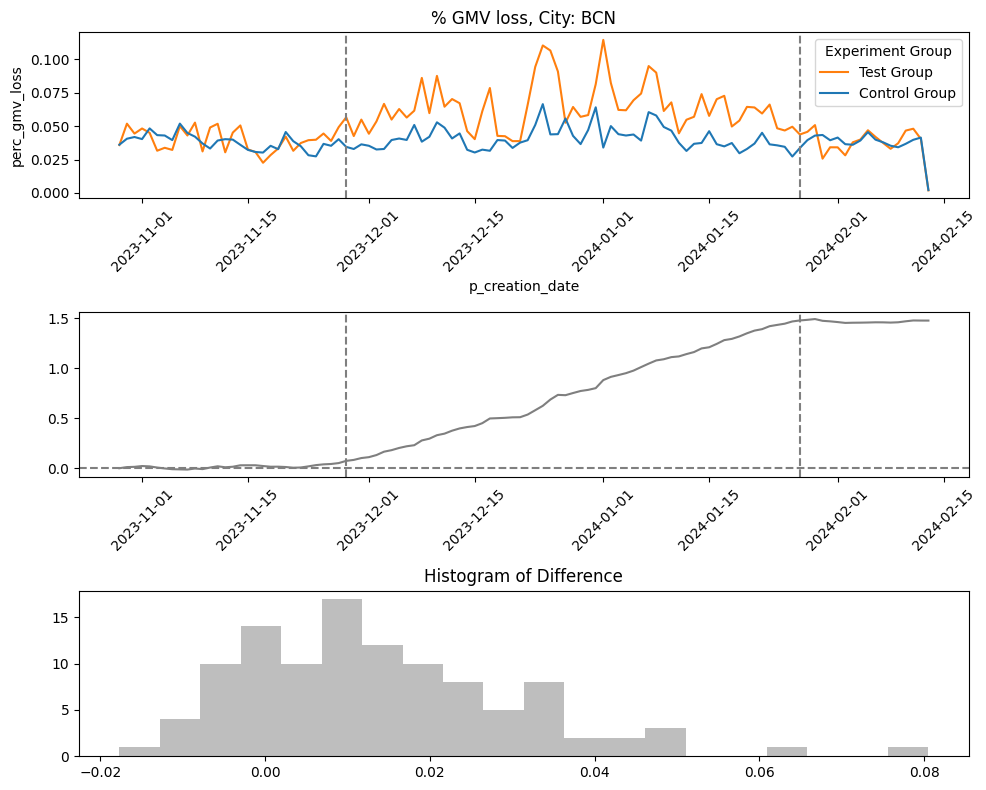

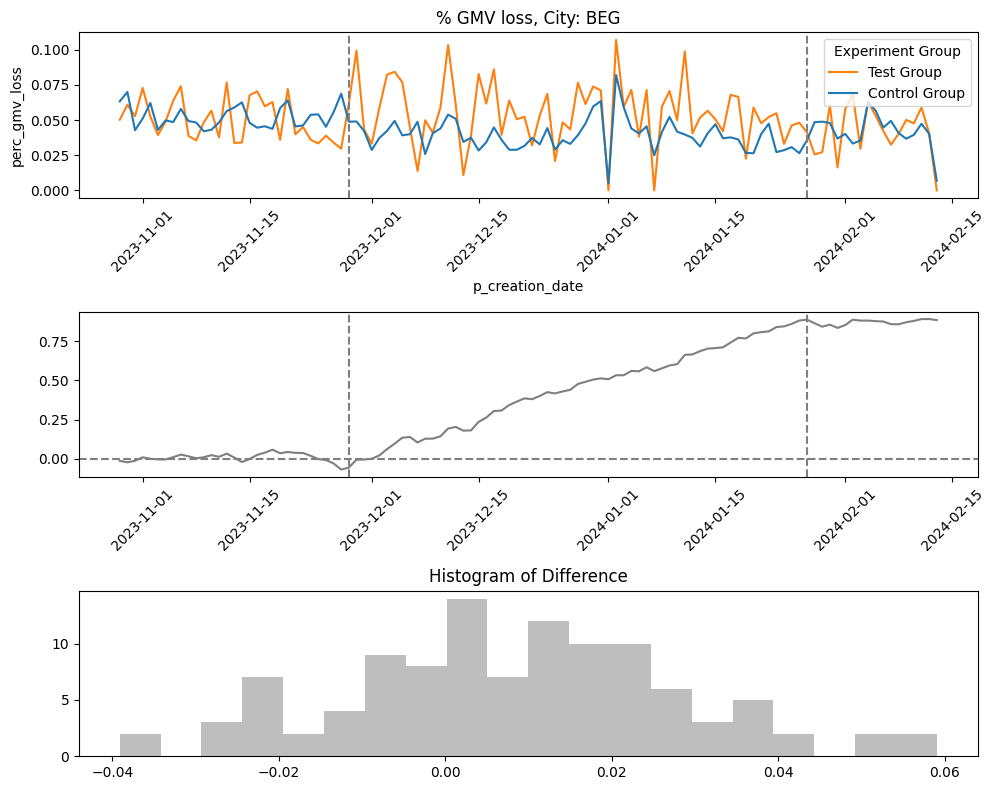

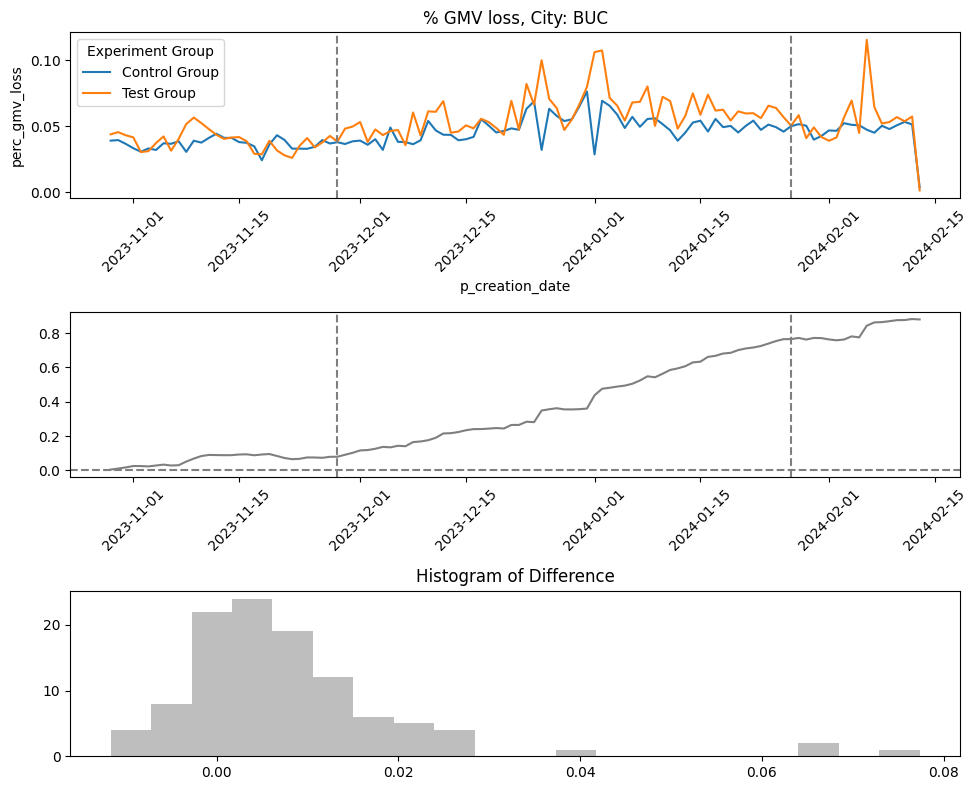

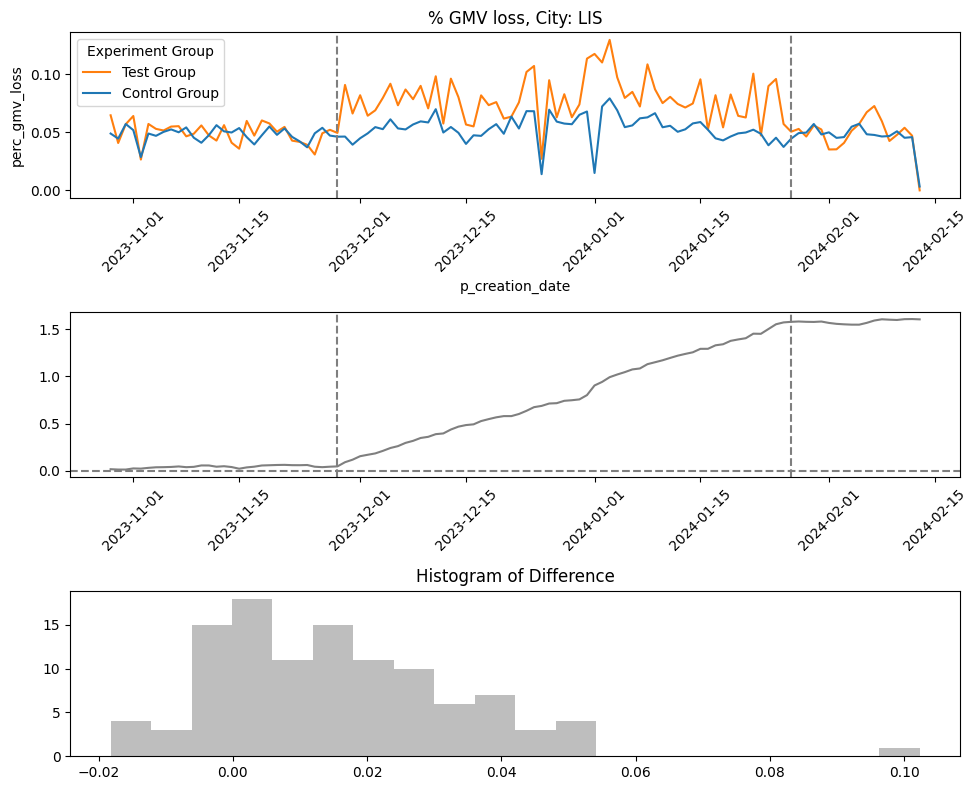

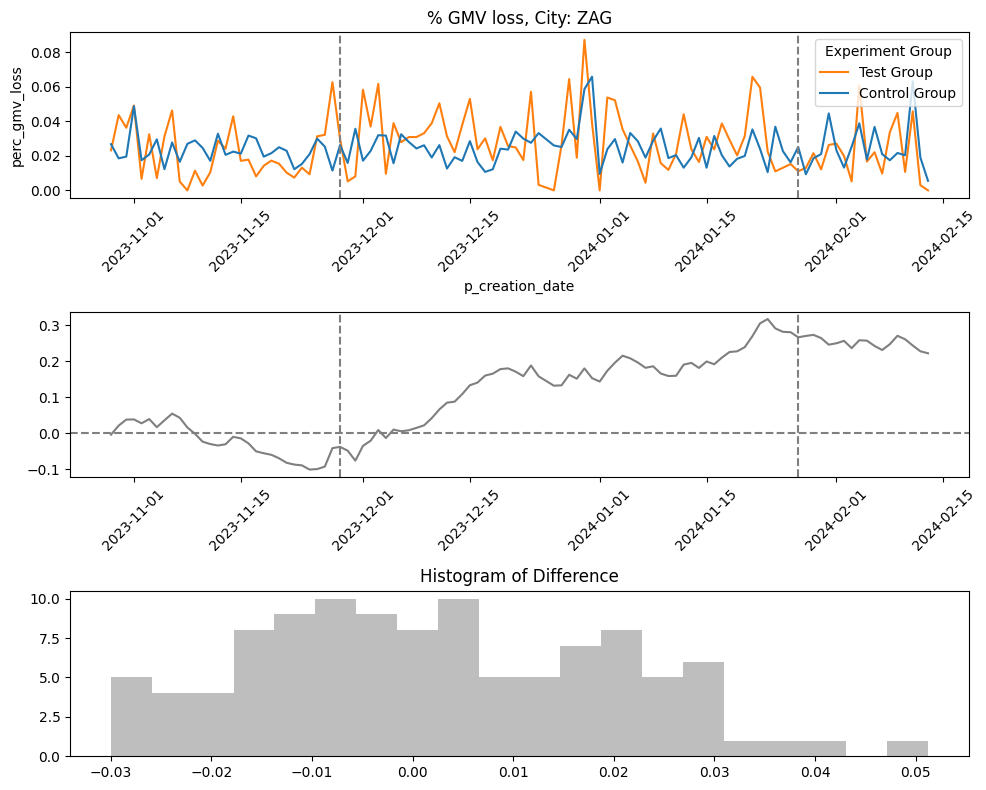

In [206]:
#plots per city
grouped = df.groupby('order_city_code')

for city, group_data in grouped:
    plt.figure(figsize=(10, 8))
    
    #lineplot
    plt.subplot(3, 1, 1)
    plt.title(f'% GMV loss, City: {city}')
    sns.lineplot(data=group_data, 
                 x='p_creation_date', 
                 y='perc_gmv_loss', 
                 hue='experiment_group',
                 palette=colors)
    plt.xticks(rotation=45)
    plt.axvline(x=pd.to_datetime(START_TEST), color=colors['Other'], linestyle='--')
    plt.axvline(x=pd.to_datetime(END_TEST), color=colors['Other'], linestyle='--')
    plt.legend(title='Experiment Group')
    
    # Calculate the cumulative difference between Test and Control Group
    diff_series = group_data.pivot(index='p_creation_date', columns='experiment_group', values='perc_gmv_loss')['Test Group'] - group_data.pivot(index='p_creation_date', columns='experiment_group', values='perc_gmv_loss')['Control Group']
    cumulative_diff = diff_series.cumsum()
    
    # Plot the second graph
    plt.subplot(3, 1, 2)
    plt.plot(cumulative_diff.index, cumulative_diff.values, color=colors['Other'])
    plt.axhline(0, color=colors['Other'], linestyle='--')
    plt.axvline(x=pd.to_datetime(START_TEST), color=colors['Other'], linestyle='--')
    plt.axvline(x=pd.to_datetime(END_TEST), color=colors['Other'], linestyle='--')
    plt.xticks(rotation=45)
    
    
    # Plot the second graph
    plt.subplot(3, 1, 3)
    plt.hist(diff_series, 
             bins=20,
             color = colors['Other'],
             alpha= 0.5)  # Adjust the number of bins as needed
    plt.title('Histogram of Difference')
    
    plt.tight_layout()
    plt.show()

All cities

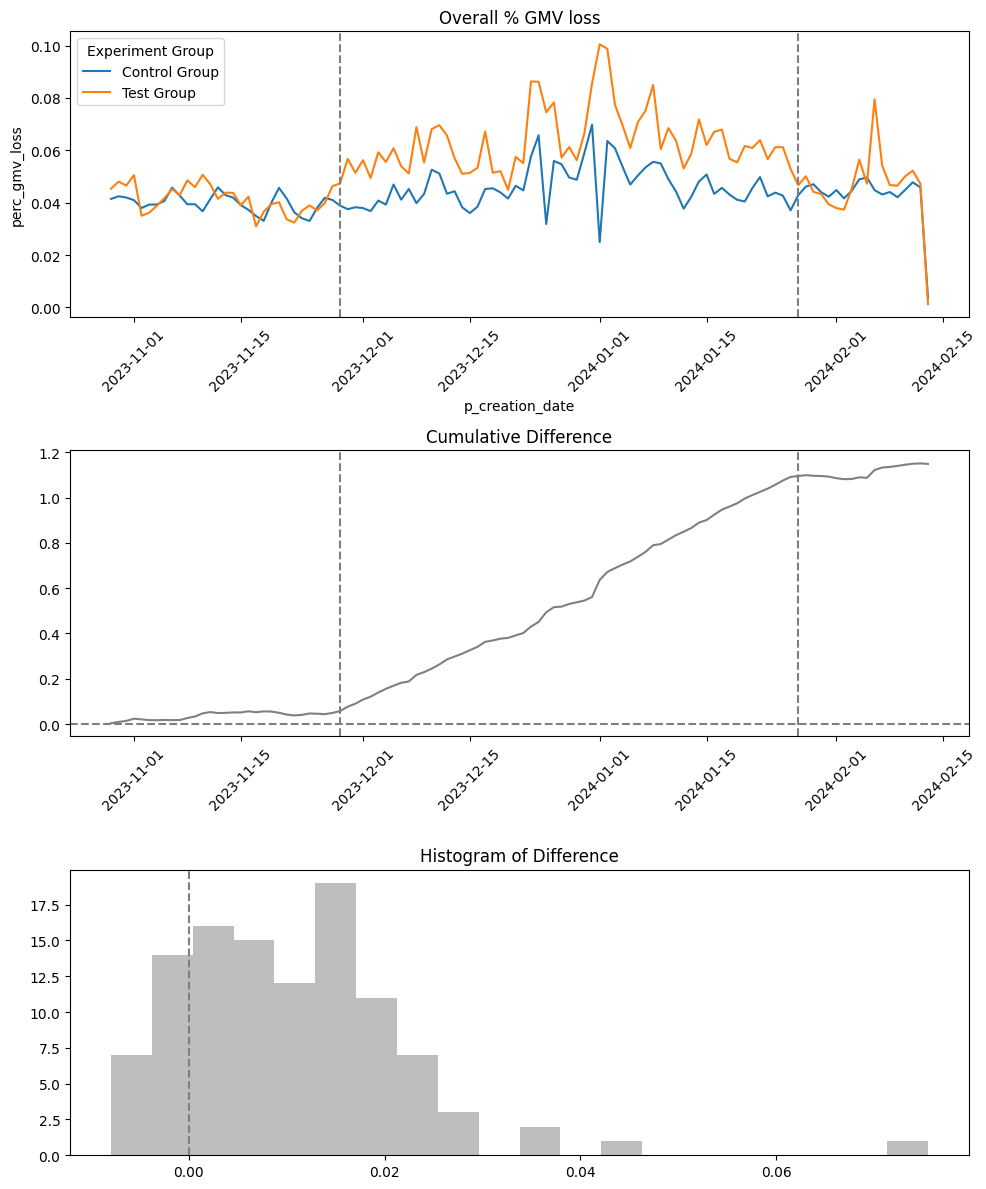

In [208]:
#all cities together
tot_cities = df.groupby(['p_creation_date','experiment_group'])[['total_value_original_eur','gmv_var_total']].sum()
tot_cities['perc_gmv_loss'] = abs(tot_cities['gmv_var_total'])/tot_cities['total_value_original_eur']
tot_cities = tot_cities.reset_index()

plt.figure(figsize=(10, 12))

# Lineplot
plt.subplot(3, 1, 1)
plt.title('Overall % GMV loss')
sns.lineplot(data=tot_cities, 
             x='p_creation_date', 
             y='perc_gmv_loss', 
             hue='experiment_group',
             palette=colors)
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime(START_TEST), color=colors['Other'], linestyle='--')
plt.axvline(x=pd.to_datetime(END_TEST), color=colors['Other'], linestyle='--')
plt.legend(title='Experiment Group')

# Calculate the cumulative difference between Test and Control Group
diff_series = tot_cities.pivot(index='p_creation_date', columns='experiment_group', values='perc_gmv_loss')['Test Group'] - tot_cities.pivot(index='p_creation_date', columns='experiment_group', values='perc_gmv_loss')['Control Group']
cumulative_diff = diff_series.cumsum()

# Plot the second graph (line plot of cumulative difference)
plt.subplot(3, 1, 2)
plt.plot(cumulative_diff.index, cumulative_diff.values, color='gray')
plt.axhline(0, color=colors['Other'], linestyle='--')
plt.axvline(x=pd.to_datetime(START_TEST), color=colors['Other'], linestyle='--')
plt.axvline(x=pd.to_datetime(END_TEST), color=colors['Other'], linestyle='--')
plt.xticks(rotation=45)
plt.title('Cumulative Difference')

# Plot the third graph (histogram of difference values)
plt.subplot(3, 1, 3)
plt.hist(diff_series.dropna(), bins=20, color=colors['Other'], alpha=0.5)  # Adjust the number of bins as needed
plt.axvline(x=0, color=colors['Other'], linestyle='--')
plt.title('Histogram of Difference')

plt.tight_layout()
plt.show()


GMV loss in absolute value

In [190]:
#all cities together
tot_cities = df.groupby(['p_creation_date','experiment_group'])[['gmv_var_total','total_orders']].sum()
tot_cities = tot_cities.reset_index()

grouped = tot_cities.groupby('experiment_group')[['gmv_var_total','total_orders']].sum().reset_index()
grouped['gmv_loss_per_order'] = grouped['gmv_var_total']/grouped['total_orders']
grouped

,experiment_group,gmv_var_total,total_orders,gmv_loss_per_order
0,Control Group,-1.489406e+06,1404159,-1.060710
1,Test Group,-1.835497e+05,141446,-1.297667


## Task 4: Define Contribution Margin

In [8]:
q = query_engines.QueryEngines(
    query='contribution_margin.sql', 
    params=params,
    load_from_output_file=None, #with no .csv
    output_file=None, #with no .csv
    printq=None
)

df = q.query_run_starbust()

c:\Users\Jordi Cremades\Documents\Repository\utils\query_engines.py:145: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/1132d5ae1f0a43bfe14ac4b3c67a5c30262c9fda9fc70978b9a1901c447033a8


In [14]:
tot_cities = df.groupby(['experiment_group'])[['pnl_cm_eur']].sum()
tot_cities

,pnl_cm_eur
experiment_group,
Control Group,1.512932e+06
Test Group,8.639304e+04
